In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class DEAPDataset(Dataset):
    def __init__(self, feature_path, label_path, exclude_subject=None, only_subject=None, normalize=True):
        self.features = np.load(feature_path)  # shape: (32, 40, 40, 5, 63)
        self.labels = np.load(label_path)      # shape: (32, 40, 63)

        # Compute statistics for normalization if requested
        if normalize:
            all_features = []
            for subj in range(32):
                if exclude_subject is not None and subj == exclude_subject:
                    continue
                if only_subject is not None and subj != only_subject:
                    continue

                # Reshape to get all features for this subject
                subj_features = self.features[subj].transpose(0, 1, 3, 2).reshape(-1, 40, 5)  # Result: (N, 40, 5)
                all_features.append(subj_features)

            if all_features:  # Check if list is not empty
                all_features = np.concatenate(all_features, axis=0)
                self.mean = np.mean(all_features, axis=0)
                self.std = np.std(all_features, axis=0) + 1e-8
            else:
                # Default if no subjects selected
                self.mean = 0
                self.std = 1
        else:
            self.mean = 0
            self.std = 1

        # Prepare samples
        self.samples = []
        for subj in range(32):
            if exclude_subject is not None and subj == exclude_subject:
                continue
            if only_subject is not None and subj != only_subject:
                continue

            for trial in range(40):
                for win in range(63):
                    x = self.features[subj, trial, :, :, win]
                    y = self.labels[subj, trial, win]
                    self.samples.append((x, y, subj))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y, subj = self.samples[idx]
        # Normalize the data
        x = (x - self.mean) / self.std
        return torch.tensor(x, dtype=torch.float32), int(y)

    def get_subject_data(self, subject):
        return [(torch.tensor((x - self.mean) / self.std, dtype=torch.float32), int(y))
                for x, y, subj in self.samples if subj == subject]

In [4]:
# class CommonFeatureExtractor(nn.Module):
#     def __init__(self, input_dim=200):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.fc3 = nn.Linear(128, 64)
#         self.bn3 = nn.BatchNorm1d(64)
#         self.dropout = nn.Dropout(0.1)
#         self.act = nn.LeakyReLU()

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # [batch, 40, 5] → [batch, 200]
#         x = self.act(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.act(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
#         x = self.act(self.bn3(self.fc3(x)))
#         return x

class CommonFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=5, hidden_size=128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128 * 2, 64)  # Bidirectional output

    def forward(self, x):
        x = x.view(x.size(0), 40, 5)  # Reshape to (batch, time, features)
        _, h = self.gru(x)  # h: (2, batch, 128)
        h = torch.cat([h[0], h[1]], dim=1)  # (batch, 256)
        out = self.fc(h)  # (batch, 64)
        return out


class SubjectSpecificMapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(64, 32)
        self.bn = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.1)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class SubjectSpecificClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(32, 4)

    def forward(self, x):
        return self.fc(x)

In [5]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        features = F.normalize(features, dim=1)
        batch_size = features.shape[0]

        # Handle case where batch size is 1
        if batch_size <= 1:
            return torch.tensor(0.0, device=features.device, requires_grad=True)

        sim_matrix = torch.matmul(features, features.T) / self.temperature
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(features.device)
        logits_mask = torch.ones_like(mask) - torch.eye(batch_size).to(features.device)
        mask = mask * logits_mask

        # Handle case where there are no positive pairs
        if mask.sum() == 0:
            return torch.tensor(0.0, device=features.device, requires_grad=True)

        exp_sim = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-9)
        loss = - (mask * log_prob).sum() / (mask.sum() + 1e-9)
        return loss

class MMDLoss(nn.Module):
    def __init__(self, kernel_mul=2.0, num_kernels=5):
        super().__init__()
        self.kernel_mul = kernel_mul
        self.num_kernels = num_kernels

    def gaussian_kernel(self, source, target):
        total = torch.cat([source, target], dim=0)

        # Handle small batch sizes
        if total.shape[0] <= 1:
            return torch.tensor(0.0, device=source.device, requires_grad=True)

        total0 = total.unsqueeze(0)
        total1 = total.unsqueeze(1)
        L2_distance = ((total0 - total1) ** 2).sum(2)

        # Prevent division by zero
        bandwidth = torch.mean(L2_distance.detach()) + 1e-8
        bandwidth_list = [bandwidth * (self.kernel_mul ** i) for i in range(self.num_kernels)]
        kernels = [torch.exp(-L2_distance / bw) for bw in bandwidth_list]
        return sum(kernels) / len(kernels)

    def forward(self, source, target):
        source = source.view(source.size(0), -1)
        target = target.view(target.size(0), -1)

        # Handle empty batches
        if source.shape[0] == 0 or target.shape[0] == 0:
            return torch.tensor(0.0, device=source.device, requires_grad=True)

        kernels = self.gaussian_kernel(source, target)
        batch_size = source.size(0)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        return torch.mean(XX + YY - XY - YX)

class ContrastiveLossLcon2(nn.Module):
    def __init__(self, feature_dim=32, num_classes=4, tau=0.1, gamma=0.5, queue_size=1024):
        super().__init__()
        self.tau = tau
        self.gamma = gamma
        self.prototypes = nn.Parameter(torch.randn(num_classes, feature_dim))
        self.register_buffer("queue", torch.randn(queue_size, feature_dim))
        self.queue = F.normalize(self.queue, dim=-1)

    def forward(self, z_t, pseudo_labels):
        # Handle empty batches
        if z_t.shape[0] == 0:
            return torch.tensor(0.0, device=z_t.device, requires_grad=True)

        z_t = F.normalize(z_t, dim=-1)
        device = z_t.device
        pseudo_labels = pseudo_labels.to(device)

        pos_proto = self.prototypes.to(device)[pseudo_labels]

        # Compute positive and negative logits
        pos_logits = torch.sum(z_t * pos_proto, dim=-1) / self.tau

        # Handle case where queue is empty
        if self.queue.shape[0] == 0:
            return self.gamma * F.cross_entropy(pos_logits.unsqueeze(1), torch.zeros(z_t.size(0), dtype=torch.long, device=device))

        neg_logits = torch.matmul(z_t, self.queue.to(device).T) / self.tau
        logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
        labels = torch.zeros(z_t.size(0), dtype=torch.long).to(device)

        loss = F.cross_entropy(logits, labels)
        self._dequeue_and_enqueue(z_t)
        return self.gamma * loss

    @torch.no_grad()
    def _dequeue_and_enqueue(self, embeddings):
        embeddings = embeddings.detach().to(self.queue.device)
        batch_size = embeddings.size(0)
        queue_size = self.queue.size(0)

        if batch_size >= queue_size:
            self.queue = embeddings[-queue_size:]
        else:
            self.queue = torch.cat([self.queue[batch_size:], embeddings], dim=0)

class GeneralizedCrossEntropy(nn.Module):
    def __init__(self, q=0.7, weight=None):
        super().__init__()
        self.q = q
        self.weight = weight  # class weights (tensor)

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)

        # Handle empty batches
        if targets.shape[0] == 0:
            return torch.tensor(0.0, device=logits.device, requires_grad=True)

        targets_onehot = F.one_hot(targets, num_classes=probs.shape[1]).float()
        probs = torch.sum(probs * targets_onehot, dim=1)

        if self.weight is not None:
            weights = self.weight[targets]
            loss = (1 - probs ** self.q) / self.q
            return (weights * loss).mean()
        else:
            return ((1 - probs ** self.q) / self.q).mean()

In [6]:
def get_target_batch(dataset, exclude, batch_size=64):
    """Get a batch of data from target subjects"""
    for subj in range(32):
        if subj != exclude:
            data = dataset.get_subject_data(subj)
            if len(data) >= batch_size:
                indices = torch.randperm(len(data))[:batch_size]
                x, y = zip(*[data[i] for i in indices])
                return torch.stack(x), torch.tensor(y)

    # Fallback: Return a small batch if no subject has enough data
    all_data = []
    for subj in range(32):
        if subj != exclude:
            all_data.extend(dataset.get_subject_data(subj))

    if len(all_data) == 0:
        # Empty tensor with correct shape as a fallback
        empty_sample = next(iter(dataset))
        return torch.zeros((0, *empty_sample[0].shape), dtype=torch.float32), torch.zeros(0, dtype=torch.long)

    indices = torch.randperm(len(all_data))[:min(batch_size, len(all_data))]
    x, y = zip(*[all_data[i] for i in indices])
    return torch.stack(x), torch.tensor(y)

def plot_confusion_matrix(y_true, y_pred, subject_idx):
    """Create and save confusion matrix plot"""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Subject {subject_idx+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'plots/confmat_subject{subject_idx+1}.png')
    plt.close()

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------ Training Function ------------------
def train_all_subjects(feature_path, label_path, num_epochs=100, batch_size=64, warmup_epochs=15):
    print("\n🚀 Training on all subjects together with contrastive + domain adaptation")

    dataset = DEAPDataset(feature_path, label_path, normalize=True)
    indices = list(range(len(dataset)))
    targets = [label for _, label in dataset]
    train_idx, test_idx, _, _ = train_test_split(
        indices, targets, test_size=0.2, stratify=targets, random_state=42
    )

    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # Init models
    cfe = CommonFeatureExtractor().to(device)
    sfe = SubjectSpecificMapper().to(device)
    ssc = SubjectSpecificClassifier().to(device)

    # Init losses

    labels_np = np.array([label for _, label in dataset])
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_np), y=labels_np)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    loss_con1 = SupervisedContrastiveLoss(temperature=0.07).to(device)
    loss_mmd = MMDLoss().to(device)
    loss_con2 = ContrastiveLossLcon2().to(device)
    loss_cls = GeneralizedCrossEntropy(q=0.5, weight=class_weights).to(device)

    optimizer = torch.optim.AdamW(
        list(cfe.parameters()) + list(sfe.parameters()) + list(ssc.parameters()),
        lr=1e-3, weight_decay=1e-4
    )

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True )

    best_acc = 0
    for epoch in range(num_epochs):
        cfe.train()
        sfe.train()
        ssc.train()

        epoch_loss, correct, total = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            z_common = cfe(xb)
            z_subject = sfe(z_common)
            logits = ssc(z_subject)

            if epoch < warmup_epochs:
                loss = loss_con1(z_common, yb)
            else:
                with torch.no_grad():
                    pseudo_logits = ssc(sfe(cfe(xb)))
                    pseudo_labels = pseudo_logits.argmax(dim=1)
                loss = loss_cls(logits, yb) + \
                       0.5 * loss_con2(z_subject, pseudo_labels) + \
                       0.1 * loss_mmd(z_common, z_common)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f}")

        # Validation
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            cfe.eval(); sfe.eval(); ssc.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb = xb.to(device)
                    z = sfe(cfe(xb))
                    logits = ssc(z)
                    all_preds.extend(logits.argmax(1).cpu().numpy())
                    all_labels.extend(yb.numpy())
            val_acc = accuracy_score(all_labels, all_preds)
            print(f"📊 Val Acc: {val_acc:.4f}")
            scheduler.step(val_acc)
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({
                    'cfe': cfe.state_dict(),
                    'sfe': sfe.state_dict(),
                    'ssc': ssc.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch + 1
                }, f"checkpoints/best_model.pt")

    print("\n✅ Training complete.")
    print(f"Best Val Accuracy: {best_acc:.4f}")

    # Final Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - All Subjects')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('plots/confmat_all_subjects.png')
    plt.close()

    return best_acc, all_labels, all_preds

# ------------------ Main ------------------
if __name__ == "__main__":
    feature_path = "E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\de_features.npy"
    label_path = "E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\de_labels.npy"
    train_all_subjects(feature_path, label_path, num_epochs=100, batch_size=64)

<>:140: SyntaxWarning: invalid escape sequence '\F'
<>:141: SyntaxWarning: invalid escape sequence '\F'
<>:140: SyntaxWarning: invalid escape sequence '\F'
<>:141: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamza\AppData\Local\Temp\ipykernel_17508\1215193728.py:140: SyntaxWarning: invalid escape sequence '\F'
  feature_path = "E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\de_features.npy"
C:\Users\hamza\AppData\Local\Temp\ipykernel_17508\1215193728.py:141: SyntaxWarning: invalid escape sequence '\F'
  label_path = "E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\de_labels.npy"


Using device: cuda

🚀 Training on all subjects together with contrastive + domain adaptation


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] - Loss: 4.1485 - Train Acc: 0.2637
Epoch [2/100] - Loss: 4.1422 - Train Acc: 0.2522
Epoch [3/100] - Loss: 4.1396 - Train Acc: 0.2405
Epoch [4/100] - Loss: 4.1371 - Train Acc: 0.2365
Epoch [5/100] - Loss: 4.1332 - Train Acc: 0.2315
📊 Val Acc: 0.2371
Epoch [6/100] - Loss: 4.1283 - Train Acc: 0.2207
Epoch [7/100] - Loss: 4.1226 - Train Acc: 0.2240
Epoch [8/100] - Loss: 4.1154 - Train Acc: 0.2294
Epoch [9/100] - Loss: 4.1083 - Train Acc: 0.2329
Epoch [10/100] - Loss: 4.0994 - Train Acc: 0.2314
📊 Val Acc: 0.2375
Epoch [11/100] - Loss: 4.0910 - Train Acc: 0.2316
Epoch [12/100] - Loss: 4.0815 - Train Acc: 0.2356
Epoch [13/100] - Loss: 4.0719 - Train Acc: 0.2325
Epoch [14/100] - Loss: 4.0619 - Train Acc: 0.2323
Epoch [15/100] - Loss: 4.0499 - Train Acc: 0.2333
📊 Val Acc: 0.2453
Epoch [16/100] - Loss: 1.2526 - Train Acc: 0.2859
Epoch [17/100] - Loss: 0.9332 - Train Acc: 0.3964
Epoch [18/100] - Loss: 0.8499 - Train Acc: 0.4653
Epoch [19/100] - Loss: 0.7984 - Train Acc: 0.4996
Epoch

In [12]:
def load_trained_model(checkpoint_path="E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\checkpoints/best_model.pt"):
    cfe = CommonFeatureExtractor().to(device)
    sfe = SubjectSpecificMapper().to(device)
    ssc = SubjectSpecificClassifier().to(device)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    cfe.load_state_dict(checkpoint['cfe'])
    sfe.load_state_dict(checkpoint['sfe'])
    ssc.load_state_dict(checkpoint['ssc'])

    cfe.eval()
    sfe.eval()
    ssc.eval()
    return cfe, sfe, ssc


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamza\AppData\Local\Temp\ipykernel_17508\533575171.py:1: SyntaxWarning: invalid escape sequence '\F'
  def load_trained_model(checkpoint_path="E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\checkpoints/best_model.pt"):


In [13]:
def test_model(feature_path, label_path, checkpoint_path="E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/FYP_2/Hamza/checkpoints/best_model.pt", batch_size=64):
    print("🔍 Testing saved model...")

    # Load the model
    cfe, sfe, ssc = load_trained_model(checkpoint_path)

    # Prepare dataset
    dataset = DEAPDataset(feature_path, label_path, normalize=True)
    indices = list(range(len(dataset)))
    labels = [label for _, label in dataset]
    _, test_idx, _, _ = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=42)
    test_set = Subset(dataset, test_idx)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            z = sfe(cfe(xb))
            logits = ssc(z)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {acc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("plots/test_confmat.png")
    plt.close()

    return acc, all_labels, all_preds


In [15]:
if __name__ == "__main__":
    feature_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_features.npy"
    label_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_labels.npy"
    test_model(feature_path, label_path)


🔍 Testing saved model...
✅ Test Accuracy: 0.6395


In [16]:
from sklearn.manifold import TSNE

def plot_tsne_features(cfe, sfe, ssc, feature_path, label_path, layer="sfe", num_samples=2000):
    dataset = DEAPDataset(feature_path, label_path, normalize=True)
    indices = list(range(len(dataset)))
    labels = [label for _, label in dataset]
    _, test_idx, _, _ = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=42)
    test_set = Subset(dataset, test_idx)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

    all_feats, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            z_cfe = cfe(xb)                     # 64-d
            z_sfe = sfe(z_cfe)                  # 32-d
            feats = z_sfe if layer == "sfe" else z_cfe
            all_feats.append(feats.cpu())
            all_labels.append(yb)

            if len(torch.cat(all_feats)) >= num_samples:
                break

    all_feats = torch.cat(all_feats)[:num_samples]
    all_labels = torch.cat(all_labels)[:num_samples]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000)
    tsne_feats = tsne.fit_transform(all_feats)

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_feats[:, 0], tsne_feats[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(f"t-SNE of {'SFE' if layer == 'sfe' else 'CFE'} features")
    plt.savefig(f"plots/tsne_{layer}_features.png")
    plt.show()


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


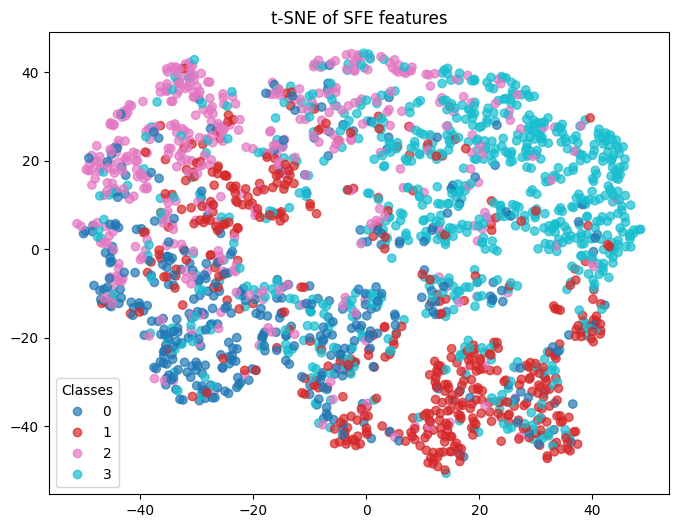

In [17]:
if __name__ == "__main__":
    feature_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_features.npy"
    label_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_labels.npy"

    # Load the model
    cfe, sfe, ssc = load_trained_model("E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/FYP_2/Hamza/checkpoints/best_model.pt")

    # Plot t-SNE from either 'cfe' or 'sfe'
    plot_tsne_features(cfe, sfe, ssc, feature_path, label_path, layer="sfe")


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


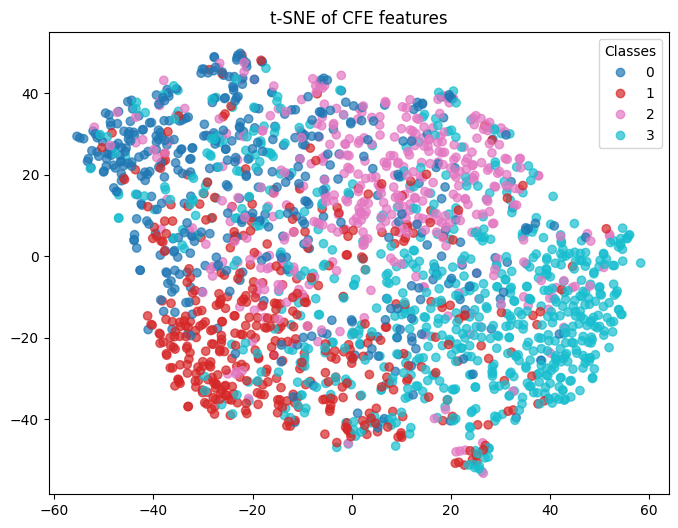

In [18]:
plot_tsne_features(cfe, sfe, ssc, feature_path, label_path, layer="cfe")
